Creating OpenAI gym Envs from SystemDynamics objects.

In [1]:
from gym import Env
from gym.envs.classic_control.rendering import Viewer
from gym.spaces import Box
from numpy import Inf

class SystemDynamicsEnv(Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, system_dynamics, init_state, times, animator=None, atol=1e-6, rtol=1e-6):
        self.system_dynamics = system_dynamics
        self.times = times
        self.animator = animator
        self.atol = atol
        self.rtol = rtol
        
        self.observation_space = Box(-Inf, Inf, (system_dynamics.n,))
        self.action_space = Box(-Inf, Inf, (system_dynamics.m,))
        
        self.state = None
        self.time_step = None
        
        self.viewer = None
        
    def step(self, action):
        assert(self.action_space.contains(action))
        
        state = self.state
        initial_time = self.times[self.time_step]
        final_time = self.times[self.time_step + 1]
        self.state = self.system_dynamics.step(state, action, initial_time, final_time)
        
        assert self.observation_space.contains(self.state)
        
        self.time_step += 1
        return self.state, 0, False, {}
    
    def reset(self):
        self.state = init_state
        self.time_step = 0
        return self.state
        
    def render(self, mode='human'):
        if self.viewer is None:
            self.viewer = Viewer(500, 500)
            self.animator.set_viewer(self.viewer)
        self.animator.render(self.state)
        self.viewer.render()
    
    def close(self):
        if self.viewer:
            self.viewer.close()
        self.viewer = None

Animator class specification.

In [2]:
class Animator:
    def set_viewer(self, viewer):
        raise NotImplementedError
        
    def render(self, state):
        raise NotImplementedError

Testing on inverted pendulum system.

In [3]:
from gym.envs.classic_control.rendering import FilledPolygon, Line, Transform

class InvertedPendulumAnimator(Animator):
    def __init__(self, inverted_pendulum, pixels_per_meter):
        self.inverted_pendulum = inverted_pendulum
        self.ppm = pixels_per_meter
        self.viewer = None
        self.xform = None
        
    def set_viewer(self, viewer):
        _, length, _ = self.inverted_pendulum.params
        length *= self.ppm
        width = length / 10
        
        self.viewer = viewer
        
        link = FilledPolygon([(0, 0), (0, length), (width, length), (width, 0)])
        self.xform = Transform()
        self.xform.set_translation((self.viewer.width - width) // 2, self.viewer.height // 2)
        link.add_attr(self.xform)
        self.viewer.add_geom(link)
        
        ground = Line((0, self.viewer.height // 2), (self.viewer.width, self.viewer.height // 2))
        self.viewer.add_geom(ground)
        
    def render(self, state):
        theta, _ = state
        self.xform.set_rotation(-theta)

In [4]:
from numpy import identity

from core.controllers import FBLinController, LQRController
from core.systems import InvertedPendulum

inverted_pendulum = InvertedPendulum(m=0.25, l=0.5)

Q = 10 * identity(2)
R = identity(1)
lqr = LQRController.build(inverted_pendulum, Q, R)
fb_lin = FBLinController(inverted_pendulum, lqr)

In [5]:
from numpy import array, linspace

init_state = array([1, 0])
times = linspace(0, 10, 1000 + 1)
animator = InvertedPendulumAnimator(inverted_pendulum, 100)
env = SystemDynamicsEnv(inverted_pendulum, init_state, times, animator)

In [6]:
from numpy import zeros

states = zeros((len(times), inverted_pendulum.n))
states[0] = env.reset()
actions = zeros((len(times) - 1, inverted_pendulum.m))

for step, time in enumerate(times[:-1]):
    env.render()
    state = states[step]
    action = fb_lin.eval(state, time)
    states[step + 1], _, _, _ = env.step(action)
    actions[step] = action
env.render()
env.close()

In [7]:
from matplotlib.pyplot import subplots, show

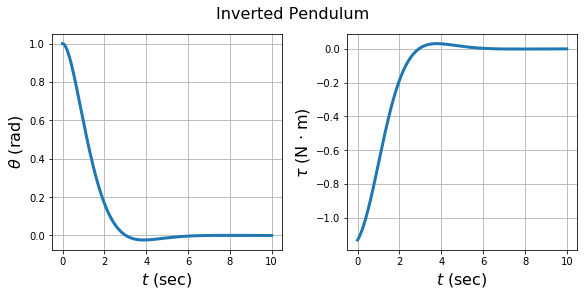

In [8]:
data = [(times, states[:, 0]), (times[:-1], actions)]
ylabels = ['$\\theta$ (rad)', '$\\tau$ (N $\\cdot$ m)']
fig, axs = subplots(1, 2, figsize=(8, 4), constrained_layout=True)

fig.suptitle('Inverted Pendulum', fontsize=16)
for (xdata, ydata), ylabel, ax in zip(data, ylabels, axs):
    ax.plot(xdata, ydata, linewidth=3)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
       
show()